The goal of this notebook is to construct linear state observers based on the models generated by each model reduction method

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
import mat73
from scipy import signal
import control

import opinf


config = dotenv_values(".env")
from util import *

In [3]:
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/threeSegmentData200Timesteps/"
# Read in system matrices
systemMats = np.load(filepath + "romSystemMatrices_12dim_5train_25test.npz")
# ERA matrices
A_era = systemMats["A_era"]
B_era = systemMats["B_era"]
C_era = systemMats["C_era"]
D_era = systemMats["D_era"]
# DMDc Matrices
A_dmdc = systemMats["A_dmdc"]
B_dmdc = systemMats["B_dmdc"]
C_dmdc = systemMats["C_dmdc"]
# Opinf Matrices
A_opInf = systemMats["A_opInf"]
B_opInf = systemMats["B_opInf"]
C_opInf = systemMats["C_opInf"]

# LOpInf Matrices
A_lopInf = systemMats["A_lopinf"]
B_lopInf = systemMats["B_lopinf"]
C_lopInf = systemMats["C_lopinf"]
D_lopInf = systemMats["D_lopinf"]

# Read in offset vector
x0 = systemMats["x0"]

# Observability study

In [4]:
print(A_dmdc.T.shape, C_dmdc.T.shape)

(12, 12) (12, 40)


In [18]:
# Check observability of lopinf system
print(np.linalg.matrix_rank(control.obsv(A_era, C_era)))

12


The goal of this section is to determine the observability characteristics of each system description

In [23]:
# Use scipy signal library to place observer poles
poles = [-0.3, -0.35, -0.4, -0.45, -0.5, -0.55, -0.6, -0.65, -0.7, -0.75, -0.8, -0.85]
L = signal.place_poles(A_lopInf.T, C_lopInf.T, poles,rtol=1,maxiter=5000).gain_matrix.T

ValueError: The poles you've chosen can't be placed. Check the controllability matrix and try another set of poles

In [20]:
# ERA Observer Gains
L_era = control.place(A_era.T, C_era.T, [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21])
L_era= L_era.T

# # DMDc Observer Gains
# L_dmdc = control.place(A_dmdc.T, C_dmdc.T, [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21])
# L_dmdc= L_dmdc.T

# # Opinf Observer Gains
# L_opInf = control.place(A_opInf.T, C_opInf.T, [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21])
# L_opInf= L_opInf.T

# LOpInf Observer Gains
# L_lopInf = control.place(A_lopInf_min.T, C_lopInf_min.T, [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21])
L_lopInf = control.acker(A_lopInf.T, C_lopInf.T, [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21])
L_lopInf= L_lopInf.T



Run Trial with Observer

In [10]:
# Load in data
data = np.load(filepath + "processedDataSet.npz")
# Read in a trial
trial = 0
# Read in the data for the specific trial
Y_fom = data["reducedCenterlineData"][:,:,trial]
Y0 = data["reducedCenterlineData"][:,0,trial]
Y_fom[:,:] = Y_fom[:,:] - Y0[:].reshape(-1,1)
U_fom = data["inputData"][:,:,trial]
timesteps = Y_fom.shape[1]


In [12]:
# Initialize observer state and output for each ROM method
# ERA
x_hat_era = np.zeros((A_era.shape[0], timesteps)) # Closed loop era observer
x_hat_ol_era = np.zeros((A_era.shape[0], timesteps)) # Open loop era observer
y_hat_era = np.zeros((C_era.shape[0], timesteps)) # Closed loop era observer
y_hat_ol_era = np.zeros((C_era.shape[0], timesteps)) # Open loop era observer
# # DMDc
# x_hat_dmdc = np.zeros((A_dmdc.shape[0], timesteps)) # Closed loop dmdc observer
# x_hat_ol_dmdc = np.zeros((A_dmdc.shape[0], timesteps)) # Open loop dmdc observer
# y_hat_dmdc = np.zeros((C_dmdc.shape[0], timesteps)) # Closed loop dmdc observer
# y_hat_ol_dmdc = np.zeros((C_dmdc.shape[0], timesteps)) # Open loop dmdc observer
# # Opinf
# x_hat_opInf = np.zeros((A_opInf.shape[0], timesteps)) # Closed loop opinf observer
# x_hat_ol_opInf = np.zeros((A_opInf.shape[0], timesteps)) # Open loop opinf observer
# y_hat_opInf = np.zeros((C_opInf.shape[0], timesteps)) # Closed loop opinf observer
# y_hat_ol_opInf = np.zeros((C_opInf.shape[0], timesteps)) # Open loop opinf observer
# LOpinf
# # x_hat_lopInf = np.zeros((A_lopInf.shape[0], timesteps)) # Closed loop lopinf observer
x_hat_ol_lopInf = np.zeros((A_lopInf.shape[0], timesteps)) # Open loop lopinf observer
# # y_hat_lopInf = np.zeros((C_lopInf.shape[0], timesteps)) # Closed loop lopinf observer
y_hat_ol_lopInf = np.zeros((C_lopInf.shape[0], timesteps)) # Open loop lopinf observer



# Iterate through each timestep applying observer update law
for i in range(timesteps-1):
    # Update observer states
    x_hat_era[:,i+1] = A_era @ x_hat_era[:,i] +B_era@U_fom[:,i] - L_era @ (y_hat_era[:,i] - Y_fom[:,i]) # Closed loop era observer
    x_hat_ol_era[:,i+1] = A_era @ x_hat_ol_era[:,i] +B_era@U_fom[:,i] # Open loop era observer
    # x_hat_dmdc[:,i+1] = A_dmdc @ x_hat_dmdc[:,i] +B_dmdc@U_fom[:,i] - L_dmdc @ (y_hat_dmdc[:,i] - Y_fom[:,i]) # Closed loop dmdc observer
    # x_hat_ol_dmdc[:,i+1] = A_dmdc @ x_hat_ol_dmdc[:,i] +B_dmdc@U_fom[:,i] # Open loop dmdc observer
    # # x_hat_opInf[:,i+1] = A_opInf @ x_hat_opInf[:,i] +B_opInf@U_fom[:,i] - L_opInf @ (y_hat_opInf[:,i] - Y_fom[:,i]) # Closed loop opinf observer
    # x_hat_ol_opInf[:,i+1] = A_opInf @ x_hat_ol_opInf[:,i] +B_opInf@U_fom[:,i] # Open loop opinf observer
    # # x_hat_lopInf[:,i+1] = A_lopInf @ x_hat_lopInf[:,i] +B_lopInf@U_fom[:,i] - L_lopInf @ (y_hat_lopInf[:,i] - Y_fom[:,i]) # Closed loop lopinf observer
    x_hat_ol_lopInf[:,i+1] = A_lopInf @ x_hat_ol_lopInf[:,i] +B_lopInf@U_fom[:,i] # Open loop lopinf observer


    # Update observer output
    y_hat_era[:,i+1] = C_era @ x_hat_era[:,i+1] + D_era @ U_fom[:,i] # Closed loop era observer
    y_hat_ol_era[:,i+1] = C_era @ x_hat_ol_era[:,i+1] + D_era @ U_fom[:,i] # Open loop era observer
    # y_hat_dmdc[:,i+1] = C_dmdc @ x_hat_dmdc[:,i+1]  # Closed loop dmdc observer
    # y_hat_ol_dmdc[:,i+1] = C_dmdc @ x_hat_ol_dmdc[:,i+1]  # Open loop dmdc observer
    # y_hat_opInf[:,i+1] = C_opInf @ x_hat_opInf[:,i+1] # Closed loop opinf observer
    # y_hat_ol_opInf[:,i+1] = C_opInf @ x_hat_ol_opInf[:,i+1] # Open loop opinf observer
    # # y_hat_lopInf[:,i+1] = C_lopInf @ x_hat_lopInf[:,i+1] # Closed loop lopinf observer
    y_hat_ol_lopInf[:,i+1] = C_lopInf @ x_hat_ol_lopInf[:,i+1] # Open loop lopinf observer
    




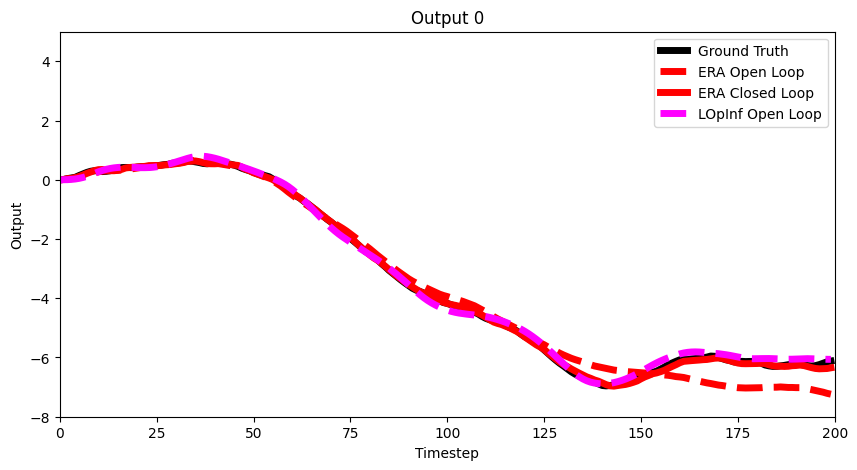

In [13]:
# plot first output from observer against ground truth with open loop responses in dashed lines and closed loop responses in solid lines
plt.figure(figsize=(10,5))
plt.plot(Y_fom[0,:], label="Ground Truth", color="black", linewidth=5)
plt.plot(y_hat_ol_era[0,:], "--", label="ERA Open Loop", color="red", linewidth=5)
plt.plot(y_hat_era[0,:], label="ERA Closed Loop", color="red", linewidth=5)
# plt.plot(y_hat_ol_dmdc[0,:], "--", label="DMDc Open Loop", color="blue", linewidth=5)
# plt.plot(y_hat_dmdc[0,:], label="DMDc Closed Loop", color="blue", linewidth=5)
# plt.plot(y_hat_ol_opInf[0,:], "--", label="OpInf Open Loop", linewidth=5)
# plt.plot(y_hat_opInf[0,:], label="OpInf Closed Loop", linewidth=5)
plt.plot(y_hat_ol_lopInf[0,:], "--", label="LOpInf Open Loop", color="magenta", linewidth=5)
# plt.plot(y_hat_lopInf[0,:], label="LOpInf Closed Loop")
plt.xlabel("Timestep")
plt.ylabel("Output")
plt.title("Output 0")
plt.xlim([0, 200])
plt.ylim([-8, 5])

plt.legend()
plt.show()


In [ ]:
# Generate open and closed loop responses for each observer for every trial
# FOM
Y_fom = data["reducedCenterlineData"][:,:,:]
U_fom = data["inputData"][:,:,:]
# subtract initial condition from Y_fom for each trial
for i in range(Y_fom.shape[2]):
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y_fom[:,0,i].reshape(-1,1)

# Initialize arrays to store data
# ERA
x_hat_era = np.zeros((A_era.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Closed loop era observer
x_hat_ol_era = np.zeros((A_era.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Open loop era observer
y_hat_era = np.zeros((C_era.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Closed loop era observer
y_hat_ol_era = np.zeros((C_era.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Open loop era observer
# DMDc
x_hat_dmdc = np.zeros((A_dmdc.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Closed loop dmdc observer
x_hat_ol_dmdc = np.zeros((A_dmdc.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Open loop dmdc observer
y_hat_dmdc = np.zeros((C_dmdc.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Closed loop dmdc observer
y_hat_ol_dmdc = np.zeros((C_dmdc.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Open loop dmdc observer
# Opinf
x_hat_opInf = np.zeros((A_opInf.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Closed loop opinf observer
x_hat_ol_opInf = np.zeros((A_opInf.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Open loop opinf observer
y_hat_opInf = np.zeros((C_opInf.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Closed loop opinf observer
y_hat_ol_opInf = np.zeros((C_opInf.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Open loop opinf observer
# LOpinf
x_hat_lopInf = np.zeros((A_lopInf.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Closed loop lopinf observer
x_hat_ol_lopInf = np.zeros((A_lopInf.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Open loop lopinf observer  
y_hat_lopInf = np.zeros((C_lopInf.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Closed loop lopinf observer
y_hat_ol_lopInf = np.zeros((C_lopInf.shape[0], timesteps, data["reducedCenterlineData"].shape[2])) # Open loop lopinf observer

# Iterate through each trial
for trial in range(data["reducedCenterlineData"].shape[2]):
    # Iterate through each timestep applying observer update law
    for i in range(timesteps-1):
        # Update observer states
        x_hat_era[:,i+1,trial] = A_era @ x_hat_era[:,i,trial] +B_era@U_fom[:,i,trial] - L_era @ (y_hat_era[:,i,trial] - Y_fom[:,i,trial]) # Closed loop era observer
        x_hat_ol_era[:,i+1,trial] = A_era @ x_hat_ol_era[:,i,trial] +B_era@U_fom[:,i,trial] # Open loop era observer
        # x_hat_dmdc[:,i+1,trial] = A_dmdc @ x_hat_dmdc[:,i,trial] +B_dmdc@U_fom[:,i,trial] - L_dmdc @ (y_hat_dmdc[:,i,trial] - Y_fom[:,i,trial]) # Closed loop dmdc observer
        # x_hat_ol_dmdc[:,i+1,trial] = A_dmdc @ x_hat_ol_dmdc[:,i,trial] +B_dmdc@U_fom[:,i,trial] # Open loop dmdc observer
        # x_hat_opInf[:,i+1,trial] = A_opInf @ x_hat_opInf[:,i,trial] +B_opInf@U_fom[:,i,trial] - L_opInf @ (y_hat_opInf[:,i,trial] - Y_fom[:,i,trial]) # Closed loop opinf observer
        # x_hat_ol_opInf[:,i+1,trial] = A_opInf @ x_hat_ol_opInf[:,i,trial] +B_opInf@U_fom[:,i,trial] # Open loop opinf observer
        # x_hat_lopInf[:,i+1,trial] = A_lopInf @ x_hat_lopInf[:,i,trial] +B_lopInf@U_fom[:,i,trial] - L_lopInf @ (y_hat_lopInf[:,i,trial] - Y_fom[:,i,trial]) # Closed loop lopinf observer
        # x_hat_ol_lopInf[:,i+1,trial] = A_lopInf @ x_hat_ol_lopInf[:,i,trial] +B_lopInf@U_fom[:,i,trial] # Open loop lopinf observer

        # Update observer output
        y_hat_era[:,i+1,trial] = C_era @ x_hat_era[:,i+1,trial] + D_era @ U_fom[:,i,trial] # Closed loop era observer
        y_hat_ol_era[:,i+1,trial] = C_era @ x_hat_ol_era[:,i+1,trial] + D_era @ U_fom[:,i,trial] # Open loop era observer
        # y_hat_dmdc[:,i+1,trial] = C_dmdc @ x_hat_dmdc[:,i+1,trial] # Closed loop dmdc observer
        # y_hat_ol_dmdc[:,i+1,trial] = C_dmdc @ x_hat_ol_dmdc[:,i+1,trial]  # Open loop dmdc observer
        # y_hat_opInf[:,i+1,trial] = C_opInf @ x_hat_opInf[:,i+1,trial] # Closed loop opinf observer
        # y_hat_ol_opInf[:,i+1,trial] = C_opInf @ x_hat_ol_opInf[:,i+1,trial] # Open loop opinf observer
        # y_hat_lopInf[:,i+1,trial] = C_lopInf @ x_hat_lopInf[:,i+1,trial] # Closed loop lopinf observer
        # y_hat_ol_lopInf[:,i+1,trial] = C_lopInf @ x_hat_ol_lopInf[:,i+1,trial] # Open loop lopinf observer
        

In [ ]:
# Plot results for a specific trial with open loop responses in dashed lines and closed loop responses in solid lines and ground truth in black

trial = 5
plt.figure()
plt.plot(Y_fom[0,:,trial], label="Ground Truth", color="black", linewidth=5)
plt.plot(y_hat_ol_era[0,:,trial], "--", label="ERA Open Loop", color="red", linewidth=5)
plt.plot(y_hat_era[0,:,trial], label="ERA Closed Loop", color="red", linewidth=5)
# plt.plot(y_hat_ol_dmdc[0,:,trial], "--", label="DMDc Open Loop", color="blue", linewidth=5)
# plt.plot(y_hat_dmdc[0,:,trial], label="DMDc Closed Loop", color="blue", linewidth=5)
# # plt.plot(y_hat_ol_opInf[0,:,trial], "--", label="OpInf Open Loop", color="green", linewidth=5)
# # plt.plot(y_hat_opInf[0,:,trial], label="OpInf Closed Loop", color="green", linewidth=5)
# plt.plot(y_hat_ol_lopInf[0,:,trial], "--", label="LOpInf Open Loop", color="magenta", linewidth=5)
# plt.plot(y_hat_lopInf[0,:,trial], label="LOpInf Closed Loop", color="magenta", linewidth=5)
plt.xlabel("Timestep")
plt.ylabel("x")
plt.title("x")
plt.legend()
plt.show()


In [ ]:
# Compute open and closed loop RMS errors for each method in each trial
# Initialize arrays to store open loop and closed loop RMS errors
rms_era = np.zeros((2, data["reducedCenterlineData"].shape[2])) # ERA
rms_dmdc = np.zeros((2, data["reducedCenterlineData"].shape[2])) # DMDc
rms_opInf = np.zeros((2, data["reducedCenterlineData"].shape[2])) # OpInf
rms_lopInf = np.zeros((2, data["reducedCenterlineData"].shape[2])) # LOpInf
# Iterate through each trial
for trial in range(data["reducedCenterlineData"].shape[2]):
    # Compute open loop RMS error
    rms_era[0,trial] = np.sqrt(np.mean((Y_fom[:,:,trial] - y_hat_ol_era[:,:,trial])**2))
    rms_dmdc[0,trial] = np.sqrt(np.mean((Y_fom[:,:,trial] - y_hat_ol_dmdc[:,:,trial])**2))
    rms_opInf[0,trial] = np.sqrt(np.mean((Y_fom[:,:,trial] - y_hat_ol_opInf[:,:,trial])**2))
    rms_lopInf[0,trial] = np.sqrt(np.mean((Y_fom[:,:,trial] - y_hat_ol_lopInf[:,:,trial])**2))
    # Compute closed loop RMS error
    rms_era[1,trial] = np.sqrt(np.mean((Y_fom[:,:,trial] - y_hat_era[:,:,trial])**2))
    rms_dmdc[1,trial] = np.sqrt(np.mean((Y_fom[:,:,trial] - y_hat_dmdc[:,:,trial])**2))
    rms_opInf[1,trial] = np.sqrt(np.mean((Y_fom[:,:,trial] - y_hat_opInf[:,:,trial])**2))
    rms_lopInf[1,trial] = np.sqrt(np.mean((Y_fom[:,:,trial] - y_hat_lopInf[:,:,trial])**2))


In [ ]:
# Bar plot with error bars of open loop and closed loop RMS errors for each method where open loop and closed loop responses are adjacent
fig, ax = plt.subplots()

# ax.figure(figsize=(10,5))
# plt.bar(np.arange(3)-0.5, [np.mean(rms_era[0,:]), np.mean(rms_dmdc[0,:]), np.mean(rms_opInf[0,:])], yerr=[np.std(rms_era[0,:]), np.std(rms_dmdc[0,:]), np.std(rms_opInf[0,:])], color=['r','b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
# plt.bar(np.arange(3)+0.5, [np.mean(rms_era[1,:]), np.mean(rms_dmdc[1,:]), np.mean(rms_opInf[1,:])], yerr=[np.std(rms_era[1,:]), np.std(rms_dmdc[1,:]), np.std(rms_opInf[1,:])], color=['r','b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')
# plt.xticks(np.arange(6), ["ERA", "DMDc", "OpInf", "ERA", "DMDc", "OpInf"])

# ax.bar(np.arange(0,4,2)-0.45, [np.mean(rms_era[0,:]), np.mean(rms_dmdc[0,:])], yerr=[np.std(rms_era[0,:]), np.std(rms_dmdc[0,:])], color=['r','b'],align='center',alpha=0.5,ecolor='black',capsize=10)
# ax.bar(np.arange(0,4,2)+0.45, [np.mean(rms_era[1,:]), np.mean(rms_dmdc[1,:])], yerr=[np.std(rms_era[1,:]), np.std(rms_dmdc[1,:])], color=['r','b'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')


ax.bar(np.arange(0,2,2)-0.45, [np.mean(rms_era[0,:])], yerr=[np.std(rms_era[0,:])], color=['r'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,2,2)+0.45, [np.mean(rms_era[1,:])], yerr=[np.std(rms_era[1,:])], color=['r'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')

# plt.set_xticks(np.arange(0,8,2))
# plt.set_xticklabels(['ERA','DMDc','OpInf','LOpInf'])

# ax.set_xticks(np.arange(0,4,2))
# ax.set_xticklabels(['ERA','DMDc'])
# ax.set_xticks(np.arange(0,2,2))
ax.set_xticklabels(['ERA'])

ax.set_ylabel("RMS Error")
ax.set_title("RMS Output Estimation Error for ERA ROM")
ax.legend(['Open Loop','Closed Loop'])

# ax.legend()
# ax.show()
